<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT22/blob/GHusername1_lab4/Lab4/GHusername1_lab4_Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Elasticity equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Elasticity equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

# Testing this from other part of LAB4
""" try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin """
    

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v) 
- <\sigma \cdot n, v>_{\Gamma}
$

To model 

We seek a finite element approximation $u\in V$ such that 

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$. 



# **Method**

**Define domain and mesh**

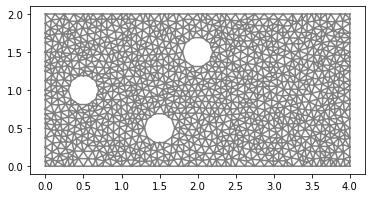

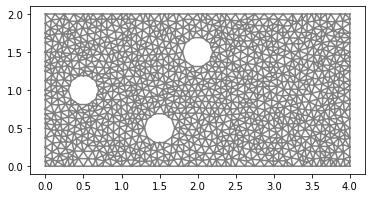

In [ ]:
# Define rectangular domain 
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

# Mesh for changing E and nu: -----------------------------------------------

mesh_Enu = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh_Enu, mesh_Enu.topology().dim())
  for cell in cells(mesh_Enu):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh_Enu = refine(mesh_Enu, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh_Enu, mesh_Enu.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

# Mesh for changing displacement: -----------------------------------------------

mesh_D = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh_D, mesh_D.topology().dim())
  for cell in cells(mesh_D):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh_D = refine(mesh_D, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh_D, mesh_D.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.figure()
plot(mesh_Enu)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, VE)
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V) 
d = Function(V)

VE_Enu = VectorElement("CG", mesh_Enu.ufl_cell(), 1)
V_Enu = FunctionSpace(mesh_Enu, VE_Enu)
# Define trial and test functions
u_Enu = TrialFunction(V_Enu)
v_Enu = TestFunction(V_Enu) 
d_Enu = Function(V_Enu)

VE_D = VectorElement("CG", mesh_D.ufl_cell(), 1)
V_D = FunctionSpace(mesh_D, VE_D)
# Define trial and test functions
u_D = TrialFunction(V_D)
v_D = TestFunction(V_D) 
d_D = Function(V_D)

**Define boundary conditions**

In [ ]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain): 
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.5, dbc_objects) # Moving circles here !!! 0.5 org
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects) # Moving circles here !!! 0.0 org

bcu_left0_Enu = DirichletBC(V_Enu.sub(0), 0.0, dbc_left)
bcu_left1_Enu = DirichletBC(V_Enu.sub(1), 0.0, dbc_left)
bcu_right0_Enu = DirichletBC(V_Enu.sub(0), 0.0, dbc_right)
bcu_right1_Enu = DirichletBC(V_Enu.sub(1), 0.0, dbc_right)
bcu_upper0_Enu = DirichletBC(V_Enu.sub(0), 0.0, dbc_upper)
bcu_upper1_Enu = DirichletBC(V_Enu.sub(1), 0.0, dbc_upper)
bcu_lower0_Enu = DirichletBC(V_Enu.sub(0), 0.0, dbc_lower)
bcu_lower1_Enu = DirichletBC(V_Enu.sub(1), 0.0, dbc_lower)
bcu_obj0_Enu = DirichletBC(V_Enu.sub(0), 0.5, dbc_objects) # Moving circles here !!! 0.5 org
bcu_obj1_Enu = DirichletBC(V_Enu.sub(1), 0.0, dbc_objects) # Moving circles here !!! 0.0 org

bcu_left0_D = DirichletBC(V_D.sub(0), 0.0, dbc_left)
bcu_left1_D = DirichletBC(V_D.sub(1), 0.0, dbc_left)
bcu_right0_D = DirichletBC(V_D.sub(0), 0.0, dbc_right)
bcu_right1_D = DirichletBC(V_D.sub(1), 0.0, dbc_right)
bcu_upper0_D = DirichletBC(V_D.sub(0), 0.0, dbc_upper)
bcu_upper1_D = DirichletBC(V_D.sub(1), 0.0, dbc_upper)
bcu_lower0_D = DirichletBC(V_D.sub(0), 0.0, dbc_lower)
bcu_lower1_D = DirichletBC(V_D.sub(1), 0.0, dbc_lower)
bcu_obj0_D = DirichletBC(V_D.sub(0), 1.0, dbc_objects) # Moving circles here !!! 0.5 org
bcu_obj1_D = DirichletBC(V_D.sub(1), 0.2, dbc_objects) # Moving circles here !!! 0.0 org


#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]

bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

bcu_Enu = [bcu_left0_Enu, bcu_left1_Enu, bcu_right0_Enu, bcu_right1_Enu, bcu_upper0_Enu, bcu_upper1_Enu, bcu_lower0_Enu, bcu_lower1_Enu, bcu_obj0_Enu, bcu_obj1_Enu]

bcu_D = [bcu_left0_D, bcu_left1_D, bcu_right0_D, bcu_right1_D, bcu_upper0_D, bcu_upper1_D, bcu_lower0_D, bcu_lower1_D, bcu_obj0_D, bcu_obj1_D]



# **Results**

**Define and solve variational problem**

In [ ]:
f = Expression(("0.0","0.0"), element = V.ufl_element())
f_Enu = Expression(("0.0","0.0"), element = V_Enu.ufl_element())
f_D = Expression(("0.0","0.0"), element = V_D.ufl_element())

dim = u.geometric_dimension()
dim_Enu = u_Enu.geometric_dimension()
dim_D = u_Enu.geometric_dimension()

E = 1.0e10                # Youngs modulus
nu = 0.3                  # Poisson ratio
mu = E*0.5/(1+nu)
lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

E_Enu = 10 * 1.0e10       # Youngs modulus x10 changes
nu_Enu = 0.4              # Poisson ratio 0.3 org
mu_Enu = E_Enu*0.5/(1+nu_Enu)
lambda_Enu = nu_Enu*E_Enu/((1.0+nu_Enu)*(1.0-2.0*nu_Enu))

E_D = 1.0e10              # Youngs modulus
nu_D = 0.3                # Poisson ratio
mu_D = E_D*0.5/(1+nu_D)
lambda_D = nu_D*E_D/((1.0+nu_D)*(1.0-2.0*nu_D))

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u,dim,lambda_):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)


# Define variational problem on residual form: r(u,v) = 0
residual = ( inner(sigma(u,dim,lambda_), epsilon(v))*dx - inner(f, v)*dx )
residual_Enu = ( inner(sigma(u_Enu,dim_Enu,lambda_Enu), epsilon(v_Enu))*dx - inner(f_Enu, v_Enu)*dx )
residual_D = ( inner(sigma(u_D,dim_D,lambda_D), epsilon(v_D))*dx - inner(f_D, v_D)*dx )

au = lhs(residual)
Lu = rhs(residual)

au_Enu = lhs(residual_Enu)
Lu_Enu = rhs(residual_Enu)

au_D = lhs(residual_D)
Lu_D = rhs(residual_D)

A = assemble(au)
b = assemble(Lu)

A_Enu = assemble(au_Enu)
b_Enu = assemble(Lu_Enu)

A_D = assemble(au_D)
b_D = assemble(Lu_D)

[bc.apply(A, b) for bc in bcu]
[bc.apply(d.vector()) for bc in bcu]

[bc_Enu.apply(A_Enu, b_Enu) for bc_Enu in bcu_Enu]
[bc_Enu.apply(d_Enu.vector()) for bc_Enu in bcu_Enu]

[bc_D.apply(A_D, b_D) for bc_D in bcu_D]
[bc_D.apply(d_D.vector()) for bc_D in bcu_D]

solve(A, d.vector(), b, "bicgstab", "default")

solve(A_Enu, d_Enu.vector(), b_Enu, "bicgstab", "default")

solve(A_D, d_D.vector(), b_D, "bicgstab", "default")



20

**Visualize solution and export files**

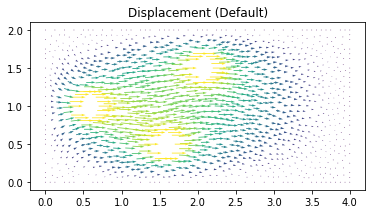

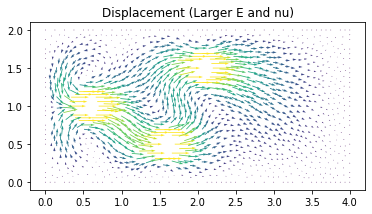

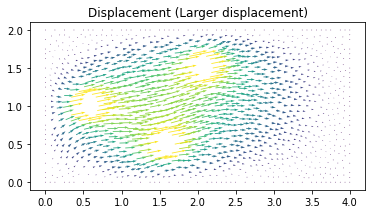

In [ ]:
u1 = project(d, V)
u1_Enu = project(d_Enu, V_Enu)
u1_D = project(d_D, V_D)

# Plot solution
plt.figure()
plot(u1, title="Displacement (Default)")

plt.figure()
plot(u1_Enu, title="Displacement (Larger E and nu)")

plt.figure()
plot(u1_D, title="Displacement (Larger displacement)")

plt.show()

**Update mesh**

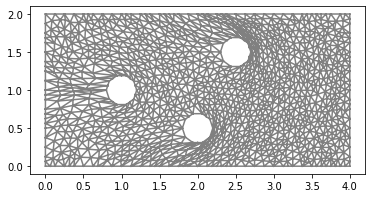

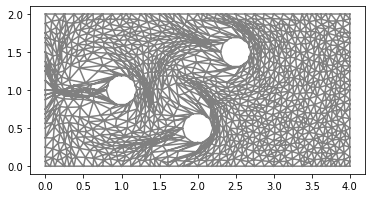

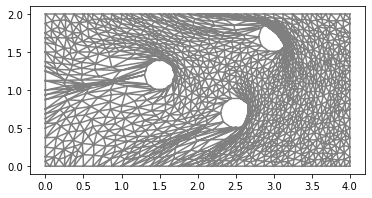

In [ ]:
ALE.move(mesh, d)
ALE.move(mesh_Enu, d_Enu)
ALE.move(mesh_D, d_D)

plt.figure()
plot(mesh)
plt.figure()
plot(mesh_Enu)
plt.figure()
plot(mesh_D)
plt.show()

# **Discussion**

A Elasticity equation was solved with a finite element method.

Observe how the elastic material (the mesh) is deformed as a response to how the cylinders are moved inside the domain.

1. Modify Young's modulus and Poisson's ratio, how does the response change? When increasing the Youngs modulus and Poisson's ratio the displacement over the domain takes a more complicated form that is not as evenly distributed as the case with lower Youngs modulus and Poisson's ratio. The mesh also gets certain areas where elements are concentrated in the "wake" of the moved cylinders. The mesh is also compressed in front of the cylinders as they are moved.

2. Change the movement of the cylinders, how does that change the deformation of the material?  Letting the cylinders move further to the right and also adding an upward movement creates two main effects compared with the smaller movement. Firstly the "wake" behind the cylinders is streched out with a thin line of compressed elements. On either side of the line in the wake the elements are streched out to fill the gap of the moved material. Secondly the front of the cylinder is flattened as the cylinder moves forward because of the compressing of the mesh that accumulates elements in front of the cylinder.

